In [162]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score


In [163]:
# 1. read the ONS file
df = pd.read_excel("data/internetreferencetables.xlsx",
                   sheet_name="IntValSA", header=3)


In [164]:
df.head()

,Time Period,All retailing excluding automotive fuel [Note 1],Predominantly food stores,Total of predominantly non-food stores [Note 2],Non-specialised stores [Note 2],"Textile, clothing and footwear stores [Note 2]",Household goods stores [Note 2],Other stores [Note 2],Non-store retailing
0,Agg/SIC,Agg 21X,Agg 1,Agg 12,47.19,Agg 5,Agg 7,Agg 13,Agg 14
1,Dataset identifier code,MZX6,MZX7,MZX8,MZX9,MZXV,MZY2,MZY3,MZY4
2,2008 Jan,219.5,36.9,91.6,16.4,23.9,21.6,29.7,91
3,2008 Feb,231.6,37.8,97.9,17.8,26,23.2,31,95.9
4,2008 Mar,238.3,37.7,99.5,18,26.6,24.3,30.5,101.2


In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 9 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   Time Period                                       215 non-null    object
 1   All retailing excluding automotive fuel [Note 1]  215 non-null    object
 2   Predominantly food stores                         215 non-null    object
 3   Total of predominantly non-food stores [Note 2]   215 non-null    object
 4   Non-specialised stores [Note 2]                   215 non-null    object
 5   Textile, clothing and footwear stores [Note 2]    215 non-null    object
 6   Household goods stores [Note 2]                   215 non-null    object
 7   Other stores [Note 2]                             215 non-null    object
 8   Non-store retailing                               215 non-null    object
dtypes: object(9)
memory usage: 15.2+ 

In [166]:
df.shape

(215, 9)

### Data Cleaning

In [167]:
# Rename columns
df.columns = ["time_period", "all_retail_excl_autofuel", "food_stores", "non_food_stores_total", "non_specialised_stores", "textile_clothing_footwear_stores", "household_goods_stores", "other_stores", "non-store_retail"]

In [168]:
# Drop first 2 rows
df = df.iloc[2:].reset_index(drop=True)

In [169]:
df.head()

,time_period,all_retail_excl_autofuel,food_stores,non_food_stores_total,non_specialised_stores,textile_clothing_footwear_stores,household_goods_stores,other_stores,non-store_retail
0,2008 Jan,219.5,36.9,91.6,16.4,23.9,21.6,29.7,91
1,2008 Feb,231.6,37.8,97.9,17.8,26,23.2,31,95.9
2,2008 Mar,238.3,37.7,99.5,18,26.6,24.3,30.5,101.2
3,2008 Apr,247,38.8,104,18.6,27.2,25.4,32.9,104.2
4,2008 May,266.1,40.3,106.3,19.3,28.4,26.1,32.5,119.5


In [170]:
# Remove spaces after date
df['time_period'] = df['time_period'].str.strip()

# Data conversions
df['time_period'] = pd.to_datetime(df['time_period'], format="%Y %b")

cols = df.columns[1:]
df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")

In [171]:
# Melt the df
id_cols = ["time_period"]  # keep the date
value_cols = cols

df_long = df.melt(
    id_vars=id_cols,
    value_vars=value_cols,
    var_name="store_type",
    value_name="internet_value"
)

### Reshaping and new columns

In [172]:
df_long.head(10)

,time_period,store_type,internet_value
0,2008-01-01,all_retail_excl_autofuel,219.5
1,2008-02-01,all_retail_excl_autofuel,231.6
2,2008-03-01,all_retail_excl_autofuel,238.3
3,2008-04-01,all_retail_excl_autofuel,247.0
4,2008-05-01,all_retail_excl_autofuel,266.1
5,2008-06-01,all_retail_excl_autofuel,270.5
6,2008-07-01,all_retail_excl_autofuel,281.4
7,2008-08-01,all_retail_excl_autofuel,289.0
8,2008-09-01,all_retail_excl_autofuel,294.5
9,2008-10-01,all_retail_excl_autofuel,280.9


In [173]:
df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time_period     1704 non-null   datetime64[ns]
 1   store_type      1704 non-null   object        
 2   internet_value  1704 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 40.1+ KB


In [174]:
# Add month count
df_long = df_long.sort_values(['store_type', 'time_period'])
df_long['time'] = df_long.groupby('store_type').cumcount() + 1 # Number months for each sector, how far along in time we are

# Add the actual value from the previous month for the same store type. If Jan was high, Feb is likely high too. That’s short-term persistence.
df_long['last_month_value'] = df_long.groupby('store_type')['internet_value'].shift(1)

# Add last year value (the same month). For “Food stores – Feb 2015” we look up “Food stores – Feb 2014”.
df_long['last_year_value'] = df_long.groupby('store_type')['internet_value'].shift(12)

# Add the difference
df_long['diff_1_month'] = df_long['internet_value'] - df_long['last_month_value']


In [175]:
# Create a dummy column (0,1) for Covid shock
df_long['covid'] = (
    (df_long['time_period'] >= "2020-04-01") &
    (df_long['time_period'] <= "2021-03-01")
).astype(int)

In [176]:
# Create store type dummies except 'all_retail_excl_autofuel', it's baseline
store_dum = pd.get_dummies(df_long['store_type'], prefix="is", drop_first=True)
df_long = pd.concat([df_long, store_dum], axis=1)

In [177]:
# Drop rows that can't have last_year_value and last_month_value (Linear regression can’t use rows with NaN in the features)
df_long = df_long.dropna(subset=['last_month_value', 'last_year_value'])

### Linear Regression

In [178]:
# Create X and y
feature_cols = ["time", "last_month_value", "last_year_value", "covid"] + \
               [c for c in df_long.columns if c.startswith("is_")]
X = df_long[feature_cols]
y = df_long["internet_value"]

In [179]:
# Fit linear regression
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # keep time order
)

model = LinearRegression().fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

#### OLS

In [180]:
X = sm.add_constant(X_train)
model = sm.OLS(y_train, X.astype(float))
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:         internet_value   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 4.844e+04
Date:                Sun, 02 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:15:17   Log-Likelihood:                -6175.7
No. Observations:                1286   AIC:                         1.237e+04
Df Residuals:                    1275   BIC:                         1.243e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

J:\Python_projects\Retail-Internet-Sales-UK\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


#### Scatterplot actual y values vs predicted y values

Text(0.5, 1.0, 'Internet Value vs. Model Predictions')

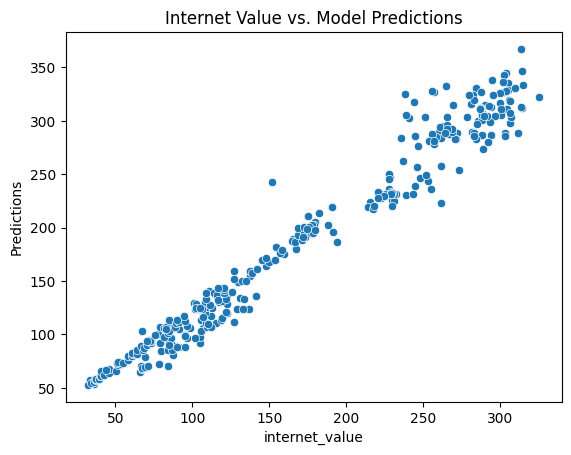

In [181]:
# Scatter plot of actual y values vs predicted values.
sns.scatterplot(x=y_test, y=y_pred_test)
plt.ylabel('Predictions')
plt.title('Internet Value vs. Model Predictions')

#### Residuals

In [182]:
# Train Residuals
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

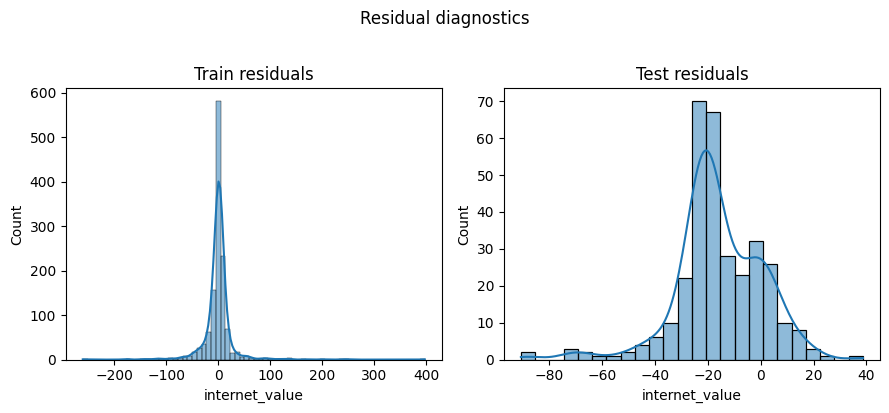

In [183]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
sns.histplot(residuals_train, ax=ax1, kde=True); ax1.set_title("Train residuals")
sns.histplot(residuals_test,  ax=ax2, kde=True); ax2.set_title("Test residuals")
fig.suptitle("Residual diagnostics", y=1.02)  # overall figure title
plt.tight_layout()

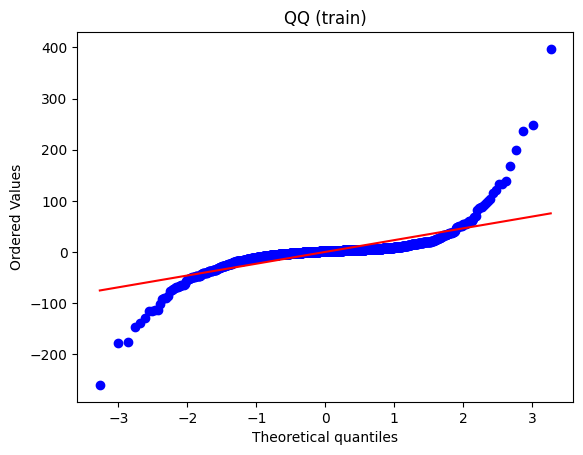

In [184]:
#QQ plot (QQ is stricter):
stats.probplot(residuals_train, dist="norm", plot=plt); plt.title("QQ (train)"); plt.show()

#### Metrics

In [185]:
# Compare predictions to the corresponding true targets

# (y_train vs y_pred_train) for training diagnostics
mean_absolute_error_train = metrics.mean_absolute_error(y_train, y_pred_train)
mean_squared_error_train = np.mean((y_train - y_pred_train)**2)
root_mean_squared_error_train = np.sqrt(np.mean((y_train - y_pred_train)**2))
r2_train = metrics.r2_score(y_train, y_pred_train)

# (y_test vs y_pred_test) for generalization performance
mean_absolute_error_test = metrics.mean_absolute_error(y_test, y_pred_test)
mean_squared_error_test = metrics.mean_squared_error(y_test, y_pred_test)
root_mean_squared_error_test = np.sqrt(np.mean((y_test - y_pred_test)**2))
r2_test = metrics.r2_score(y_test, y_pred_test)

print("Training set:")
print("  y_train                             =", y_train.shape, "(true targets for training rows)")
print("  y_pred_train                        =", y_pred_train.shape, "(predicted targets for training rows)")
print("  MAE_train (Mean Absolute Error)     =", mean_absolute_error_train)
print("  MSE_train (Mean Squared Error)      =", mean_squared_error_train)
print("  RMSE_train (Root Mean Squared Error)=", root_mean_squared_error_train)
print("  R2_train                            =", r2_train)

print("\nTest set:")
print("  y_test                              =", y_test.shape, "(true targets for test rows)")
print("  y_pred_test                         =", y_pred_test.shape, "(predicted targets for test rows)")
print("  MAE_test (Mean Absolute Error)      =", mean_absolute_error_test)
print("  MSE_test (Mean Squared Error)       =", mean_squared_error_test)
print("  RMSE_test (Root Mean Squared Error) =", root_mean_squared_error_test)
print("  R2_test                             =", r2_test)

Training set:
  y_train                             = (1286,) (true targets for training rows)
  y_pred_train                        = (1286,) (predicted targets for training rows)
  MAE_train (Mean Absolute Error)     = 13.419140610237074
  MSE_train (Mean Squared Error)      = 868.4125698473787
  RMSE_train (Root Mean Squared Error)= 29.468840660049366
  R2_train                            = 0.9973750144675779

Test set:
  y_test                              = (322,) (true targets for test rows)
  y_pred_test                         = (322,) (predicted targets for test rows)
  MAE_test (Mean Absolute Error)      = 18.43565331027381
  MSE_test (Mean Squared Error)       = 530.7498382288629
  RMSE_test (Root Mean Squared Error) = 23.03800855605499
  R2_test                             = 0.9322550494905479


In [188]:
print('In average, we miss by this much in target units (millions):',mean_absolute_error_test)
print('MAE (test):',round(mean_absolute_error_test,3),'in millions')

In average, we miss by this much in target units (millions): 18.43565331027381
MAE (test): 18.436 in millions
